In [1]:
import os
import sys
import itertools
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, spearmanr
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

sys.path.append(os.path.expanduser('~/Documents/telegates'))
from telegates.processing import regions, regions2, selectregion, spatial_mean, agg_time, deseasonalize, lag_precursor, makeindex, makeindex2, create_response, combine_index_response
from telegates.subsetting import digitize, count_combinations, split, split_compute, split_index
from telegates.utils import interpolate, select_months, data_for_pcolormesh

try: # Cartopy not working on ivm
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    pass

### Sst index, spatially

@ KNMI

In [2]:
timeagg = 21
separation = -15
#basedir = Path('/scistor/ivm/jsn295/')
basedir = Path('/nobackup/users/straaten/')
which = ['fullrecord', 'partrecord', '1990plus'][0]
#corrpattern = xr.open_dataset(basedir / f'paper2/clusters_cv_spearmanpar_varalpha_strict/sst_nhplus.{timeagg}.corr.nc', decode_times = False)
corrpattern = xr.open_dataset(basedir / f'paper4/analysis/parcor_notstrict_{which}/sst_nhplus.{timeagg}.corr.nc', decode_times = False)
whichregion = regions2.copy()
whichregion.index = ['dipole1','dipole2']
ninoregions = pd.DataFrame([[slice(-5,5),slice(-150,-90)],
                            [slice(-5,5), slice(160,-150)],
                            [slice(20,62),slice(110,-110)]], columns = whichregion.columns, index = ['nino3','nino4','pdo'])
whichregion = whichregion.append(ninoregions)
#whichregion['color'] = ['tab:red','tab:red','tab:green','tab:purple','tab:orange']
whichregion['color'] = ['black','black','tab:orange','tab:green','tab:red']

In [3]:
whichregion

,latrange,lonrange,color
dipole1,"slice(-1.5, 5.5, None)","slice(162, 169, None)",black
dipole2,"slice(10, 14, None)","slice(139.5, 150.5, None)",black
nino3,"slice(-5, 5, None)","slice(-150, -90, None)",tab:orange
nino4,"slice(-5, 5, None)","slice(160, -150, None)",tab:green
pdo,"slice(20, 62, None)","slice(110, -110, None)",tab:red


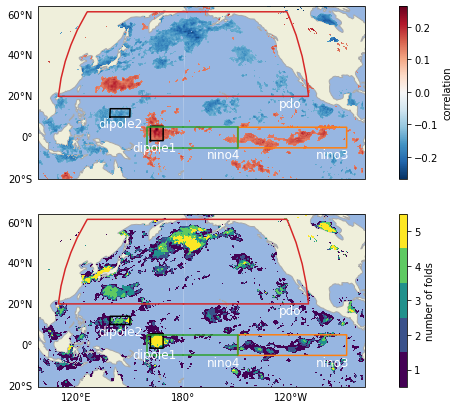

In [36]:
shading = 'flat'
proj_crs = ccrs.Robinson(central_longitude=-170)
#proj_crs = ccrs.PlateCarree()
array_crs = ccrs.PlateCarree()
latslice = slice(-20,65)
lonslice = np.concatenate([np.arange(100,180,0.25),np.arange(-180,-80,0.25)]) #slice(None) #slice(100,180)
fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs},nrows = 2, 
                         sharex = True, sharey = True, figsize = (12,7))

#fig.suptitle(f'{timeagg}, {separation}, {which}')
meancor = corrpattern['correlation'].mean('fold')
meancor = meancor.sel(lag = -(abs(separation) + timeagg), latitude = latslice, longitude = lonslice)
cor = axes[0].pcolormesh(*data_for_pcolormesh(meancor, shading = shading),transform = array_crs, cmap = 'RdBu_r')

nfolds = (~corrpattern['correlation'].isnull()).sum('fold')
nfolds = nfolds.where(nfolds!=0, np.nan)
nfolds = nfolds.sel(lag = -(abs(separation) + timeagg), latitude = latslice, longitude = lonslice)
nf = axes[1].pcolormesh(*data_for_pcolormesh(nfolds, shading = shading),transform = array_crs, cmap = plt.cm.get_cmap('viridis', 5), vmin = 0.5, vmax = 5.5)

for ax in axes:
    for region in whichregion.index:
        coords = whichregion.loc[region,['latrange','lonrange']]
        if coords['lonrange'].start < coords['lonrange'].stop:
            ax.plot([coords['lonrange'].start, coords['lonrange'].stop, coords['lonrange'].stop, coords['lonrange'].start, coords['lonrange'].start],
                    [coords['latrange'].start, coords['latrange'].start, coords['latrange'].stop, coords['latrange'].stop, coords['latrange'].start],
                    transform=array_crs, color = whichregion.loc[region,'color'], label = region)
        else: # Draw in two parts. Because it crosses the dateline
            ax.plot([180, coords['lonrange'].start, coords['lonrange'].start, 180],
                    [coords['latrange'].start, coords['latrange'].start, coords['latrange'].stop, coords['latrange'].stop],
                    transform=array_crs, color = whichregion.loc[region,'color'])
            ax.plot([-180, coords['lonrange'].stop, coords['lonrange'].stop, -180],
                    [coords['latrange'].start, coords['latrange'].start, coords['latrange'].stop, coords['latrange'].stop],
                    transform=array_crs, color = whichregion.loc[region,'color'], label = region)
        ax.text(x = coords['lonrange'].stop - 17, y = coords['latrange'].start - 5, s = region, 
                transform = array_crs, color = 'white', size = 12)
    ax.coastlines(zorder = 0, lw = 1, color = 'darkgrey')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)

axes[0].gridlines(draw_labels={"left": "y"}, lw = 0)
axes[1].gridlines(draw_labels={"bottom":"x","left": "y"}, lw = 0)
  
fig.colorbar(cor, ax = axes[0], orientation = 'vertical', label = 'correlation', pad = 0.05)
fig.colorbar(nf, ax = axes[1], orientation = 'vertical', label = 'number of folds', pad = 0.05)
plt.savefig(f'/usr/people/straaten/Pictures/pacific_predictors_{timeagg}_{separation}_{which}.png', dpi = 130)

### Sst index, temporally

@ IVM

In [2]:
index = makeindex2(deseason = True, remove_interannual=False, timeagg = 21, degree = 7).to_pandas()
index.name = 'w_pacif_dipole'

In [128]:
nino_m = pd.read_hdf('~/paper4/nino_rel_monthly.h5')
nino_m.index = pd.date_range(nino_m.index.values.min(), nino_m.index.values.max(), freq = 'MS') # Error with MS freq
nino_m.columns = pd.Index([f'nino_{i}' for i in nino_m.columns.get_level_values('clustid')],name = 'var')
nino_d = interpolate(nino_m)
pdo_m = pd.read_hdf('~/paper4/pdo_monthly.h5')
pdo_d = interpolate(pdo_m)
mjo_d = pd.read_hdf('~/paper4/mjo_daily.h5').loc[(slice(None),0),:].iloc[:,-1]
mjo_d.index = mjo_d.index.droplevel('separation')
mjo_d.name = 'MJO_rmm2'

In [129]:
indices = pd.merge(nino_d, pdo_d, how = 'outer', left_index = True, right_index = True).join(mjo_d, how = 'left').join(index, how = 'left')
indices = select_months(indices.reindex(index = index.index), [6,7,8])
indices_1979 = indices.dropna() # indices.drop('MJO_rmm2', axis = 1).dropna()
crosscor_1979 = pd.DataFrame(np.corrcoef(indices_1979.T), index = indices_1979.columns, columns = indices_1979.columns)

In [130]:
selection = ['w_pacif_dipole','nino_3', 'nino_4','PDO']

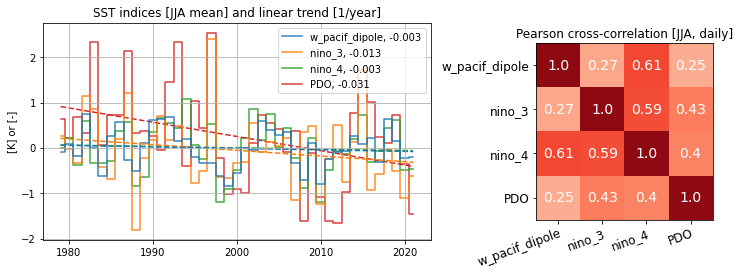

In [132]:
fig = plt.figure(figsize=(12,4),facecolor='white')

gs = GridSpec(nrows = 4, ncols=10, wspace=1, hspace = 0.4)
ax1 = fig.add_subplot(gs[:,:-4])
ax2 = fig.add_subplot(gs[:,-3:])

for zorder, key in enumerate(selection):
    smean = indices_1979.loc[:,key].groupby(indices_1979.index.year).mean()
    linreg = LinearRegression(normalize = False)
    linreg.fit(X = indices_1979.index.year.values[:,np.newaxis], y = indices_1979.loc[:,key])
    l1 = ax1.step(smean.index, smean.values,
                  label = f'{key}, {float(np.round(linreg.coef_,3))}',
                  where = 'mid', alpha = 0.9, zorder = -zorder)
    ax1.plot(smean.index,linreg.predict(X = smean.index.values[:,np.newaxis]), 
            color = l1[0].get_color(), ls = '--', zorder = -zorder + 1)
#ax1.set_ylim((-2,2.5))
#ax1.hlines(0, xmin = smean.index.min(), xmax = smean.index.max(), color = 'black', zorder = -5)
ax1.legend()
ax1.grid(zorder = -7)
ax1.set_title('SST indices [JJA mean] and linear trend [1/year]')
ax1.set_ylabel('[K] or [-]')

im = ax2.imshow(crosscor_1979.loc[selection,selection].values, vmin = -0.1, vmax = 1.1, 
                cmap = 'Reds')#, aspect = 'auto')

# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(selection)))
ax2.set_xticklabels(selection, size = 12)
ax2.set_yticks(np.arange(len(selection)))
ax2.set_yticklabels(selection, size = 12)
ax2.set_title('Pearson cross-correlation [JJA, daily]')

plt.setp(ax2.get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")

for i, var1 in enumerate(selection):
    for j, var2 in enumerate(selection):
        ax2.text(j,i,str(np.round(crosscor_1979.loc[var1,var2],2)), 
                 horizontalalignment='center',verticalalignment='center',size = 14, color = 'white')
plt.savefig('/scistor/ivm/jsn295/paper4/analysis/dipole/paper_figs/sst_index_temporally.pdf')

### T2m predictand, temporally
@ IVM

In [3]:
reduced = create_response(respagg = 31, degree = 7)

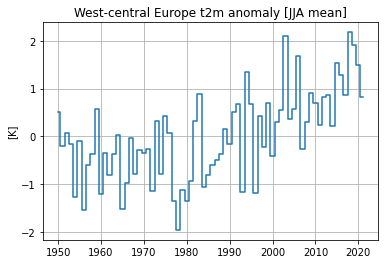

In [145]:
fig, ax = plt.subplots()
summer = select_months(reduced.to_pandas(), months = [6,7,8])
summermean = summer.groupby(summer.index.year).mean()
ax.step(summermean.index, summermean.values, where = 'mid')
ax.grid(True)
ax.set_ylabel('[K]')
ax.set_title('West-central Europe t2m anomaly [JJA mean]')
plt.savefig('/scistor/ivm/jsn295/paper4/analysis/dipole/paper_figs/t2m_response_temporally.pdf')
plt.show()

### T2m predictand, spatially
@ KNMI

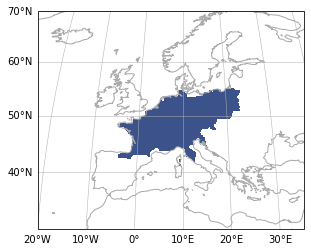

In [56]:
shading = 'flat'
proj_crs = ccrs.Robinson(central_longitude=10)
#proj_crs = ccrs.PlateCarree()
array_crs = ccrs.PlateCarree()

subdomainlats = slice(30,70)
subdomainlons = slice(-20,35) #slice(-5,24)
clusterfield = xr.open_dataarray('/nobackup/users/straaten/clusters/t2m-q095.nc').sel(nclusters = 15, latitude = subdomainlats, longitude = subdomainlons)
clusterfield = clusterfield.where(clusterfield==9, np.nan)
fig, ax = plt.subplots(subplot_kw = {'projection':proj_crs})

ax.contourf(*data_for_pcolormesh(clusterfield, shading = None),transform = array_crs)
ax.coastlines(zorder = 1, lw = 1, color = 'darkgrey')
ax.gridlines(draw_labels={"bottom":"x","left": "y"}, lw = 0.5)
plt.savefig('/usr/people/straaten/Pictures/west_central_europe.pdf')

### Combination through time
@ IVM

In [134]:
combined = combine_index_response(idx = index, idxname = '21d_west_pacific_dipole', response = reduced,
                                  lag = True, separation = -15, only_months = [6,7,8], detrend_response = False)

lagging, agg: 21, sep: -15


In [135]:
quantiles = [0.33,0.66]
overall_thresholds = combined.quantile(quantiles)
overall = count_combinations(digitized_array=digitize(combined, thresholds=overall_thresholds))

In [136]:
nyearslice = 21

centeryears = combined.index.year.unique().sort_values()[(nyearslice//2):-(nyearslice//2)]
counts = pd.DataFrame(np.nan, index = centeryears, columns = overall.stack(0).index)

for centeryear in centeryears:
    sl = slice(pd.Timestamp(f'{centeryear - nyearslice//2}-01-01'),pd.Timestamp(f'{centeryear + nyearslice//2}-12-31'))
    comb = combined.loc[sl,:] # combined contains only summer values.
    #thresholds = comb.quantile(quantiles)
    #thresholds = overall_thresholds
    thresholds = overall_thresholds.copy()
    thresholds.loc[:,'t2m-mean-anom'] = comb.quantile(quantiles).loc[:,'t2m-mean-anom'] # replacing only the t2m threshold
    exceedences = digitize(comb, thresholds=thresholds)
    count = count_combinations(digitized_array=exceedences)
    counts.loc[centeryear,:] = count.stack(0)

insync = ['sync'] + ['unsync'] * (counts.shape[-1]-2) + ['sync']
counts.columns = pd.MultiIndex.from_frame(counts.columns.to_frame().assign(diagonal = insync))

In [137]:
# Construct matrix uncertainty band. Sampling full seasons
# Thresholding here does not take into account the narrowing of the t2m range.
nrepeats = 500
samples = pd.DataFrame(np.nan, index = pd.RangeIndex(nrepeats), columns = counts.columns)
for i in range(nrepeats):
    sampled_years = np.random.randint(low = combined.index.year.min(), high = combined.index.year.max() + 1, size = nyearslice)
    draw = combined.loc[combined.index.year.map(lambda y: y in sampled_years),:]
    dummy_matrix = count_combinations(digitize(draw,thresholds = draw.quantile(quantiles)))
    samples.iloc[i,:] = dummy_matrix.stack(0)

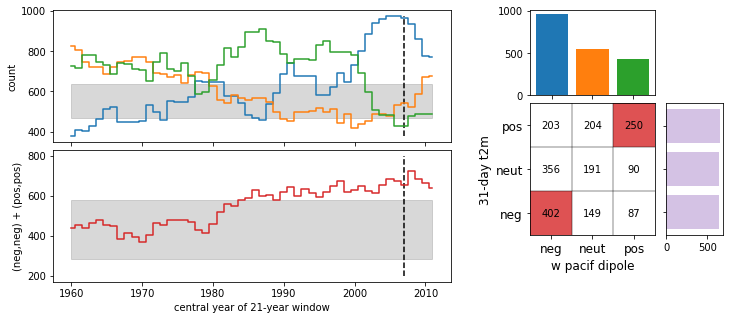

In [139]:
aliases = {0:'neg',1:'neut',2:'pos'}
example_year = 2007
boundaries = [0.025, 0.975]
fig = plt.figure(figsize=(12,5),facecolor='white')

gs = GridSpec(nrows = 6, ncols=10, wspace=0.2, hspace = 0.2)
axw = fig.add_subplot(gs[:3,:6])
axt = fig.add_subplot(gs[3:,:6])
axm = fig.add_subplot(gs[2:-1,7:-1])
axmv = fig.add_subplot(gs[:2,7:-1])
axmh = fig.add_subplot(gs[2:-1,-1:])

# West pacific plot
wpacif = counts.groupby('w_pacif_dipole', axis = 1).sum()
wpacif_bounds = samples.groupby('w_pacif_dipole', axis = 1).sum().stack().quantile(boundaries) # This assumes equal sample range. 
colors = []
for i, alias in aliases.items():
    lw = axw.step(wpacif.index, wpacif[i], label = alias, where = 'mid')
    colors.append(lw[0].get_color())
axw.fill_between(wpacif.index, y1 = wpacif_bounds.iloc[0], y2 = wpacif_bounds.iloc[1], color = 'grey', alpha = 0.3)
axw.vlines(x = example_year, ymin = wpacif.min(), ymax = wpacif.max(), ls = '--')
axw.set_xticklabels('')
axw.set_ylabel('count')

# synchronized entries
sync = counts.groupby('diagonal', axis = 1).sum()['sync']
sync_bounds = samples.groupby('diagonal', axis = 1).sum().quantile(boundaries)['sync']
axt.step(sync.index, sync.values, color = 'tab:red', where = 'mid')
axt.fill_between(sync.index, y1 = sync_bounds.iloc[0], y2 = sync_bounds.iloc[1], color = 'grey', alpha = 0.3)
axt.vlines(x = example_year, ymin = 200, ymax = 800, ls = '--')
axt.set_xlabel(f'central year of {nyearslice}-year window')
axt.set_ylabel(f'({aliases[0]},{aliases[0]}) + ({aliases[2]},{aliases[2]})')

# Example plot matrix
for sst, t2m, key in counts.columns:
    val = counts.loc[example_year,(sst,t2m)]
    if key == 'sync':
        axm.barh(width = 1, height = 1, left = sst-0.5, y = t2m, align = 'center', color = 'tab:red', alpha = 0.8)
    axm.text(x = sst, y = t2m, s = int(val),horizontalalignment='center', verticalalignment='center', color = 'black')
axm.vlines(x = [0.5,1.5], ymin = -0.5, ymax = 2.5, alpha = 0.3)
axm.hlines(y = [0.5,1.5], xmin = -0.5, xmax = 2.5, alpha = 0.3)
axm.set_xlim((-0.5,2.5))
axm.set_ylim((-0.5,2.5))

axm.set_xticks(list(aliases.keys()))
axm.set_xticklabels(list(aliases.values()), size = 12)
axm.set_xlabel('w pacif dipole', size = 12)

axm.set_yticks(list(aliases.keys()))
axm.set_yticklabels(list(aliases.values()), size = 12)
axm.set_ylabel('31-day t2m', size = 12)


# Example plot vertical
axmv.bar(wpacif.loc[example_year,:].index, wpacif.loc[example_year,:], color = colors)
axmv.set_xticklabels('')

# Example plot horizontal
t2m_counts = counts.groupby('t2m-mean-anom', axis = 1).sum()
axmh.barh(y = t2m_counts.columns, width = t2m_counts.loc[example_year], color = 'tab:purple', alpha = 0.4)
axmh.set_yticklabels('')

plt.savefig('/scistor/ivm/jsn295/paper4/analysis/dipole/paper_figs/teleconnection_moving_window.pdf')
plt.show()

### Composite teleconnection pattern
@ KNMI

contrasting pos,pos with neg, neg

In [57]:
variables = ['sst_nhplus','olr_tropics','z300_nhnorm','t2m_europe']
moments = ['preinit','preinit','postinit','valid']
moment_alias = {'preinit':'week 0-2','postinit':'week 3-5','valid':'week 5-7'}
sl = '2000-01-01_2021-08-31'
anom = 'last20'
#datapath = Path('/scistor/ivm/jsn295/paper4/analysis/dipole/composites/')
datapath = Path('/nobackup/users/straaten/paper4/analysis/dipole/composites/')
diffranges = {'sst_nhplus':3,'t2m_europe':5,'olr_tropics':35, 'z300_nhnorm':1000,'v300_nhnorm':10,
              'u300_nhnorm':12,'stream_nhnorm':1e7}

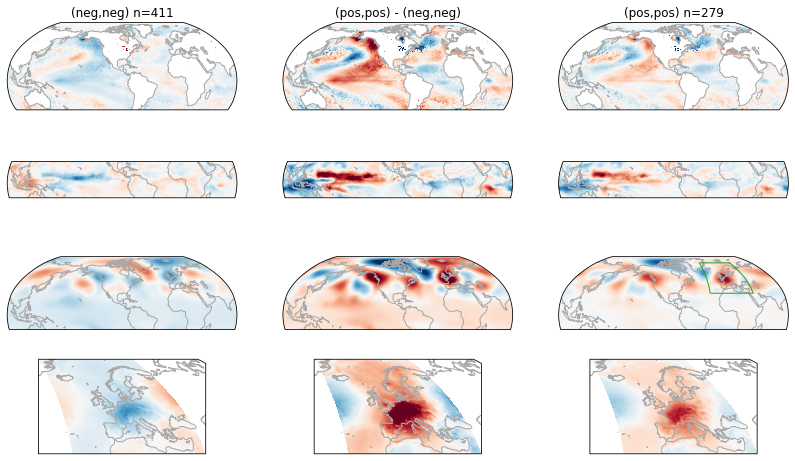

In [78]:
shading = 'flat'
proj_crs = ccrs.Robinson(central_longitude=-90)
array_crs = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows = len(variables), ncols = 3, figsize = (14,len(variables)*2),
                         facecolor='white', subplot_kw = {'projection':proj_crs})
for i, (var,moment) in enumerate(zip(variables,moments)):
    file = xr.open_dataarray(datapath / f'{sl}_{var}_anom{anom}_21.nc').sel(moment = moment)
    nsamples = eval(file.attrs['nsamples'].split(']')[-1])
    pospos = file.sel({'sst-mean-anom':2, 't2m-mean-anom':2})
    negneg = file.sel({'sst-mean-anom':0, 't2m-mean-anom':0})
    difference = pospos - negneg
    if anom in ['full','last20']:
        vmin = 0 - diffranges[var]/2
        vmax = 0 + diffranges[var]/2
    else:
        vmin = float(file.quantile(0.02))
        vmax = float(file.quantile(0.98))
    vmindiff = 0 - diffranges[var]/2
    vmaxdiff = 0 + diffranges[var]/2
    
    axes[i,0].pcolormesh(*data_for_pcolormesh(negneg, shading = shading), zorder = 1, shading = shading, 
              cmap = 'RdBu_r', vmin = vmin, vmax = vmax,transform = array_crs)
    axes[i,1].pcolormesh(*data_for_pcolormesh(difference, shading = shading), zorder = 1, shading = shading, 
              cmap = 'RdBu_r', vmin = vmindiff, vmax = vmaxdiff, transform = array_crs)
    axes[i,-1].pcolormesh(*data_for_pcolormesh(pospos, shading = shading), zorder = 1, shading = shading, 
              cmap = 'RdBu_r', vmin = vmin, vmax = vmax, transform = array_crs)
    #axes[i,0].set_xlabel(f'{var.split("_")[0]} {moment_alias[moment]}')
    
    axes[i,0].coastlines(zorder = 1, lw = 1, color = 'darkgrey')
    axes[i,1].coastlines(zorder = 1, lw = 1, color = 'darkgrey')
    axes[i,-1].coastlines(zorder = 1, lw = 1, color = 'darkgrey')
    
    if i == 0:
        axes[i,0].set_title(f'(neg,neg) n={nsamples[(0,0)]}')
        axes[i,1].set_title('(pos,pos) - (neg,neg)')
        axes[i,-1].set_title(f'(pos,pos) n={nsamples[(2,2)]}')
    
    if i == 3: # Plotting the european temperature domain for reference
        axes[2,-1].plot([float(file.longitude.max()), float(file.longitude.min()), float(file.longitude.min()), float(file.longitude.max()), float(file.longitude.max())],
                    [float(file.latitude.max()), float(file.latitude.max()), float(file.latitude.min()),float(file.latitude.min()), float(file.latitude.max())],
                    transform=array_crs, color = 'tab:green', lw = 1)
    file.close()

plt.savefig('/usr/people/straaten/Pictures/diagonal_contrast.png',dpi = 130)
plt.show()

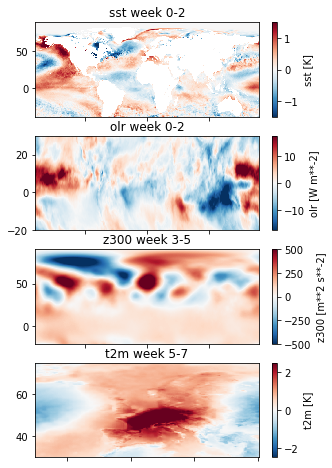

In [79]:
# For the colorbars
fig, axes = plt.subplots(nrows = len(variables), ncols = 1, figsize = (5,len(variables)*2),
                         facecolor='white')
for i, (var,moment) in enumerate(zip(variables,moments)):
    file = xr.open_dataarray(datapath / f'{sl}_{var}_anom{anom}_21.nc').sel(moment = moment)
    nsamples = eval(file.attrs['nsamples'].split(']')[-1])
    pospos = file.sel({'sst-mean-anom':2, 't2m-mean-anom':2})
    negneg = file.sel({'sst-mean-anom':0, 't2m-mean-anom':0})
    difference = pospos - negneg
    if anom in ['full','last20']:
        vmin = 0 - diffranges[var]/2
        vmax = 0 + diffranges[var]/2
    else:
        vmin = float(file.quantile(0.02))
        vmax = float(file.quantile(0.98))
    vmindiff = 0 - diffranges[var]/2
    vmaxdiff = 0 + diffranges[var]/2
    
    im = axes[i].pcolormesh(*data_for_pcolormesh(difference, shading = shading), zorder = 1, shading = shading, 
              cmap = 'RdBu_r', vmin = vmindiff, vmax = vmaxdiff)
    axes[i].set_title(f'{var.split("_")[0]} {moment_alias[moment]}')
    axes[i].set_xticklabels('')
    fig.colorbar(im, ax = axes[i], label = f'{var.split("_")[0]} [{file.units}]')
    file.close()

plt.savefig('/usr/people/straaten/Pictures/diagonal_contrast_attributes.png',dpi = 130)

### Composite modulation (timeseries)
@ IVM

By lagged ENSO, not rolling, only for a fixed slice

In [140]:
ninoregion = 3
nino_m = pd.read_hdf('~/paper4/nino_rel_monthly.h5')
nino_m.index = pd.date_range(nino_m.index.values.min(), nino_m.index.values.max(), freq = 'MS') # Error with MS freq
nino_m.columns = nino_m.columns.get_level_values('clustid')
nino_d = interpolate(nino_m).loc[:,ninoregion]

In [141]:
overall_thresholds = combined.quantile(quantiles)
sl = slice('2000-01-01','2021-12-31')
subset = combined.loc[sl,:]
thresholds = overall_thresholds.copy()
thresholds.loc[:,'t2m-mean-anom'] = subset.quantile(quantiles).loc[:,'t2m-mean-anom'] # replacing only the t2m threshold
exceedences = digitize(subset, thresholds=thresholds)
    
combs = count_combinations(exceedences)

In [143]:
separations = pd.RangeIndex(start = -320, stop = 300, step = 5, name = 'separation')
frame = pd.DataFrame(np.nan, index = separations, columns = combs.stack(0).index)

for sep in separations:
    n_lagged = lag_precursor(nino_d, separation = sep, timeagg = 1, sign = True) # Fix symmetry.
    mean_nino, std_nino, min_nino, max_nino = split_compute(exceedences, to_split = n_lagged)
    frame.loc[sep] = mean_nino.stack(0)

/scistor/ivm/jsn295/Documents/telegates/telegates/subsetting.py:41: UserWarning: to split series is 59458 longer than digitized combinations, only 2000-06-01 00:00:00 till 2021-08-29 00:00:00 can be used
  warnings.warn(f'to split series is {len(to_split.index) - len(digitized_frame.index)} longer than digitized combinations, only {match.min()} till {match.max()} can be used')
/scistor/ivm/jsn295/Documents/telegates/telegates/subsetting.py:41: UserWarning: to split series is 59458 longer than digitized combinations, only 2000-06-01 00:00:00 till 2021-08-19 00:00:00 can be used
  warnings.warn(f'to split series is {len(to_split.index) - len(digitized_frame.index)} longer than digitized combinations, only {match.min()} till {match.max()} can be used')
/scistor/ivm/jsn295/Documents/telegates/telegates/subsetting.py:41: UserWarning: to split series is 59458 longer than digitized combinations, only 2000-06-01 00:00:00 till 2021-08-09 00:00:00 can be used
  warnings.warn(f'to split series is

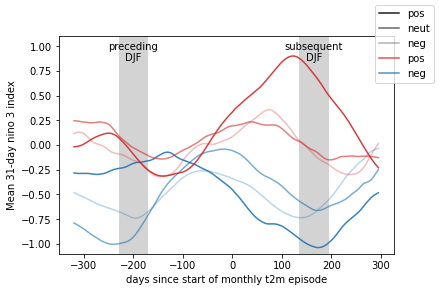

In [144]:
aliases = {2:'pos',1:'neut',0:'neg'}
t2m_colors = {0:'tab:blue',1:'grey',2:'tab:red'}
t2m_alpha = {0:0.3, 1:0.6, 2:0.9}
fig, ax = plt.subplots(facecolor='white')


for wpacif in [0,2]: # only 2 states
    for t2m in aliases.keys(): # All possibilities
        #ax.plot(frame.index, frame.loc[:,(wpacif,t2m)], color = t2m_colors[t2m], ls = '-' if wpacif == 0 else '--')
        #ax.plot(frame.index, frame.loc[:,(wpacif,t2m)], color = 'tab:red', alpha = t2m_alpha[t2m], ls = '-' if wpacif == 0 else '--')
        ax.plot(frame.index, frame.loc[:,(wpacif,t2m)], color = 'tab:red' if wpacif == 2 else 'tab:blue', alpha = t2m_alpha[t2m])

items = []
for cat in aliases.keys():
    items.append(Line2D([0],[0], color = 'black', alpha = t2m_alpha[cat]))
for wpacif in [2,0]:
    items.append(Line2D([0],[0], color = 'tab:red' if wpacif == 2 else 'tab:blue', alpha = 0.8))
fig.legend(handles = items, labels = list(aliases.values()) + ['pos','neg'])

ax.set_ylim((-1.1,1.1))

ax.axvspan(-230, -170, facecolor='lightgrey')
ax.text(x = -200, y = 0.85, s = 'preceding\nDJF',horizontalalignment='center')
ax.axvspan(135, 195, facecolor='lightgrey')
ax.text(x = 165, y = 0.85, s = 'subsequent\nDJF', horizontalalignment='center')

ax.set_xlabel('days since start of monthly t2m episode')
ax.set_ylabel(f'Mean 31-day nino {ninoregion} index')

plt.savefig('/scistor/ivm/jsn295/paper4/analysis/dipole/paper_figs/nino_modulation.pdf')
plt.show()

### Composite modulation (maps)
@ KNMI

Here include u300. perhaps SST. perhaps olr. perhaps z300. Point is to show atlantic jet for modulating positive side of teleconnection.

In [81]:
sl = '2000-01-01_2021-08-31'
anom = 'last20'
moment = 'preinit'
#datapath = Path('/scistor/ivm/jsn295/paper4/analysis/dipole/composites/')
datapath = Path('/nobackup/users/straaten/paper4/analysis/dipole/composites/')
diffranges = {'sst_nhplus':3,'t2m_europe':5,'olr_tropics':35, 'z300_nhnorm':1000,'v300_nhnorm':10,
              'u300_nhnorm':12,'stream_nhnorm':1e7}
aliases = {2:'pos',1:'neut',0:'neg'}
variables = ['sst_nhplus','u300_nhnorm']

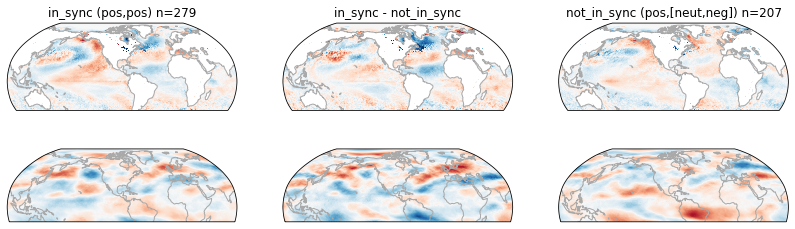

In [88]:
wpacif = 2

shading = 'flat'
proj_crs = ccrs.Robinson(central_longitude=-90)
array_crs = ccrs.PlateCarree()
fig, axes = plt.subplots(nrows = len(variables), ncols = 3, figsize = (14,len(variables)*2),
                         facecolor='white', subplot_kw = {'projection':proj_crs})

for i, var in enumerate(variables):
    file = xr.open_dataarray(datapath / f'{sl}_{var}_anom{anom}_21.nc').sel(moment = moment)
    nsamples = eval(file.attrs['nsamples'].split(']')[-1])
    # In sync samples
    insync = file.sel({'sst-mean-anom':wpacif, 't2m-mean-anom':wpacif}) # Synchronized response 
    insync_samples = nsamples[(wpacif,wpacif)]
    # Other cases (neural & opposite response)
    neutral = file.sel({'sst-mean-anom':wpacif, 't2m-mean-anom':1})
    neutral_samples = nsamples[(wpacif,1)]
    opposite = file.sel({'sst-mean-anom':wpacif, 't2m-mean-anom':2-wpacif})
    opposite_samples = nsamples[(wpacif,2-wpacif)]
    weighted_other = (neutral * neutral_samples + opposite * opposite_samples)/(neutral_samples + opposite_samples)

    difference = insync - weighted_other
    if anom in ['full','last20']:
        vmin = 0 - diffranges[var]/2
        vmax = 0 + diffranges[var]/2
    else:
        vmin = float(file.quantile(0.02))
        vmax = float(file.quantile(0.98))
    vmindiff = 0 - diffranges[var]/2
    vmaxdiff = 0 + diffranges[var]/2
    
    axes[i,0].pcolormesh(*data_for_pcolormesh(insync, shading = shading), zorder = 1, shading = shading, 
              cmap = 'RdBu_r', vmin = vmin, vmax = vmax, transform = array_crs)
    axes[i,1].pcolormesh(*data_for_pcolormesh(difference, shading = shading), zorder = 1, shading = shading, 
              cmap = 'RdBu_r', vmin = vmindiff, vmax = vmaxdiff, transform = array_crs)
    axes[i,-1].pcolormesh(*data_for_pcolormesh(weighted_other, shading = shading), zorder = 1, shading = shading, 
              cmap = 'RdBu_r', vmin = vmin, vmax = vmax, transform = array_crs)
    
    axes[i,0].coastlines(zorder = 1, lw = 1, color = 'darkgrey')
    axes[i,1].coastlines(zorder = 1, lw = 1, color = 'darkgrey')
    axes[i,-1].coastlines(zorder = 1, lw = 1, color = 'darkgrey')
    
    if i == 0:
        axes[i,0].set_title(f'in_sync ({aliases[wpacif]},{aliases[wpacif]}) n={insync_samples}')
        axes[i,1].set_title('in_sync - not_in_sync')
        axes[i,-1].set_title(f'not_in_sync ({aliases[wpacif]},[{aliases[1]},{aliases[2-wpacif]}]) n={neutral_samples + opposite_samples}')
    file.close()
plt.savefig(f'/usr/people/straaten/Pictures/positive_modulation_{moment}.png',dpi = 130)
plt.show()

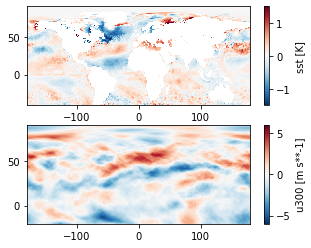

In [89]:
wpacif = 2


fig, axes = plt.subplots(nrows = len(variables), ncols = 1, figsize = (5,len(variables)*2),
                         facecolor='white')

for i, var in enumerate(variables):
    file = xr.open_dataarray(datapath / f'{sl}_{var}_anom{anom}_21.nc').sel(moment = moment)
    nsamples = eval(file.attrs['nsamples'].split(']')[-1])
    # In sync samples
    insync = file.sel({'sst-mean-anom':wpacif, 't2m-mean-anom':wpacif}) # Synchronized response 
    insync_samples = nsamples[(wpacif,wpacif)]
    # Other cases (neural & opposite response)
    neutral = file.sel({'sst-mean-anom':wpacif, 't2m-mean-anom':1})
    neutral_samples = nsamples[(wpacif,1)]
    opposite = file.sel({'sst-mean-anom':wpacif, 't2m-mean-anom':2-wpacif})
    opposite_samples = nsamples[(wpacif,2-wpacif)]
    weighted_other = (neutral * neutral_samples + opposite * opposite_samples)/(neutral_samples + opposite_samples)

    difference = insync - weighted_other
    if anom in ['full','last20']:
        vmin = 0 - diffranges[var]/2
        vmax = 0 + diffranges[var]/2
    else:
        vmin = float(file.quantile(0.02))
        vmax = float(file.quantile(0.98))
    vmindiff = 0 - diffranges[var]/2
    vmaxdiff = 0 + diffranges[var]/2
    
    im = axes[i].pcolormesh(*data_for_pcolormesh(difference, shading = shading), zorder = 1, shading = shading, 
              cmap = 'RdBu_r', vmin = vmindiff, vmax = vmaxdiff)
    fig.colorbar(im, ax = axes[i], label = f'{var.split("_")[0]} [{file.units}]')
    file.close()
plt.savefig(f'/usr/people/straaten/Pictures/positive_modulation_{moment}_attributes.png',dpi = 130)
plt.show()